In [40]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow as tf

First we will extract all the needed labels(GO term ID) from train_terms.tsv file. There are more than 40,000 labels. In order to simplify our model, we will choose the most frequent 1500 GO term IDs as labels.

In [3]:
train_terms = pd.read_csv("data/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)

(5363863, 3)


/var/folders/2w/ckrq97td6jg1frzm6lmgfc3c0000gn/T/ipykernel_95421/390216163.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)


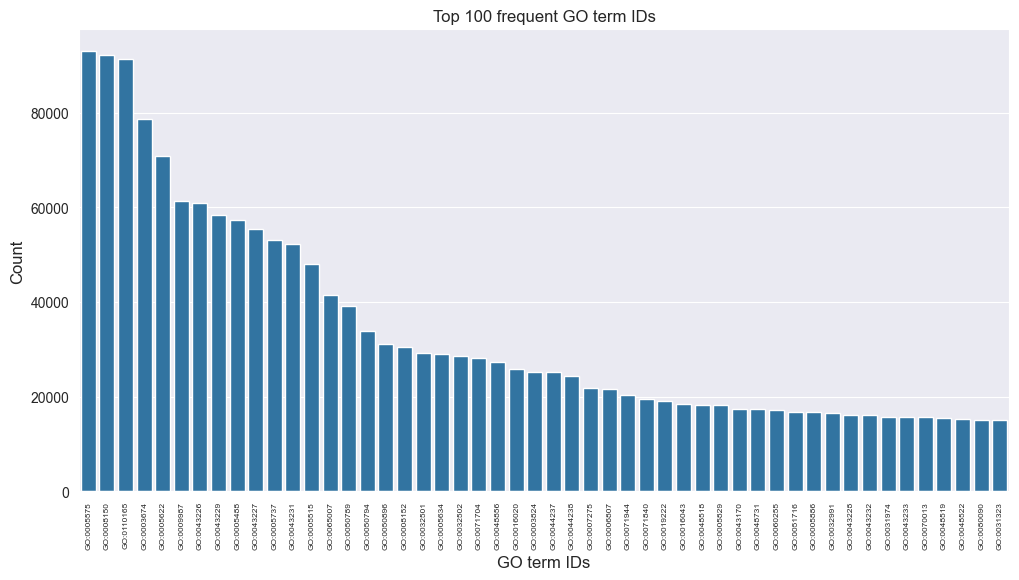

In [4]:

plot_df = train_terms['term'].value_counts().iloc[:50]
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

Keep only 2000 most frequent GO  terms. 

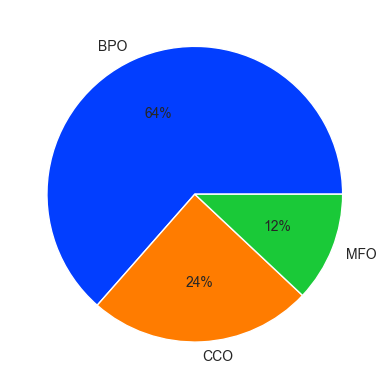

In [28]:
number_of_labels = 2000
labels = train_terms['term'].value_counts().index[:number_of_labels].tolist()
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [29]:
labels_CCO = train_terms_updated[train_terms_updated['aspect'] == 'CCO']['term'].unique().tolist()
labels_MFO = train_terms_updated[train_terms_updated['aspect'] == 'MFO']['term'].unique().tolist()
labels_BPO = train_terms_updated[train_terms_updated['aspect'] == 'BPO']['term'].unique().tolist()

print(f"CCO Labels: {len(labels_CCO)}")
print(f"MFO Labels: {len(labels_MFO)}")
print(f"BPO Labels: {len(labels_BPO)}")

CCO Labels: 291
MFO Labels: 252
BPO Labels: 1457


In [12]:
train_terms_updated.shape

(4597356, 3)

In [8]:
proteins_data_json = open("proteins_data.json")
proteins_data = json.load(proteins_data_json)

print(len(proteins_data))

142246


Create dataframe for all GO aspects

In [38]:
def create_labels_dataframe(proteins_data, labels):
    protein_ids = list(proteins_data.keys())
    
    num_proteins = len(protein_ids)
    train_labels = np.zeros((num_proteins, len(labels)))
    
    protein_to_index = {protein: idx for idx, protein in enumerate(protein_ids)}
    go_term_to_index = {go: idx for idx, go in enumerate(labels)}
    
    for protein_id, data in tqdm(proteins_data.items(), desc="Processing proteins"):
        protein_idx = protein_to_index[protein_id]
        for terms in data['GO'].values():
            for term in terms:
                if term in go_term_to_index:
                    train_labels[protein_idx, go_term_to_index[term]] = 1
    
    labels_df = pd.DataFrame(train_labels, index=protein_ids, columns=labels)
    
    return labels_df

labels_df = create_labels_dataframe(proteins_data, labels)
labels_CCO_df = create_labels_dataframe(proteins_data, labels_CCO)
labels_MFO_df = create_labels_dataframe(proteins_data, labels_MFO)
labels_BPO_df = create_labels_dataframe(proteins_data, labels_BPO)

print(labels_df.shape)
print(labels_CCO_df.shape)
print(labels_MFO_df.shape)
print(labels_BPO_df.shape)

Prepare train dataset

In [47]:
train_embeddings = np.genfromtxt('data/features_train.csv', delimiter=",")

column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

# Cut first 2 columns
train_df_cut = train_df.iloc[:, 2:]
print(train_df_cut.head)

(142246, 1026)


Start with training

In [52]:
INPUT_SHAPE = [train_df_cut.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=len(labels),activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_df_cut, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - auc_2: 0.6040 - binary_accuracy: 0.8730 - loss: nan
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - auc_2: 0.5000 - binary_accuracy: 0.9838 - loss: nan
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - auc_2: 0.5000 - binary_accuracy: 0.9839 - loss: nan
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - auc_2: 0.5000 - binary_accuracy: 0.9838 - loss: nan
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - auc_2: 0.5000 - binary_accuracy: 0.9838 - loss: nan


<Axes: title={'center': 'Accuracy'}>

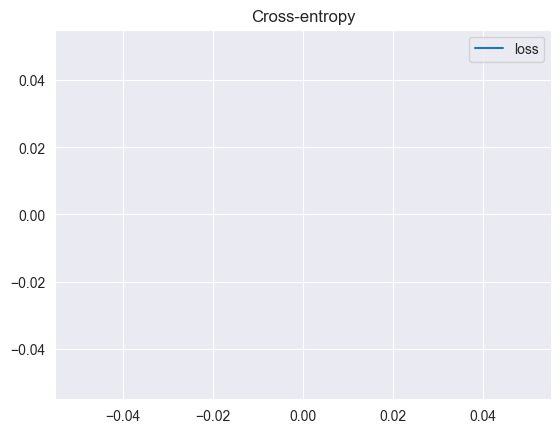

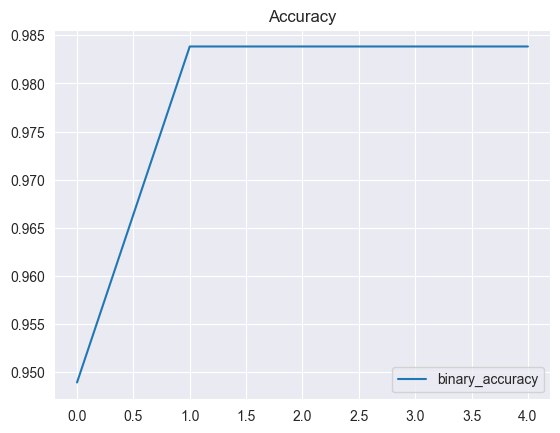

In [53]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

In [54]:
train_embeddings = np.genfromtxt('data/features_test.csv', delimiter=",")

column_num = train_embeddings.shape[1]
test_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

# Cut first 2 columns
test_df_cut = test_df.iloc[:, 2:]
print(test_df_cut.head)

(141865, 1026)
<bound method NDFrame.head of         Column_3  Column_4  Column_5  Column_6  Column_7  Column_8  Column_9  \
0            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       0.054705  0.063420 -0.015320 -0.016506  0.042195  0.021592 -0.118535   
2       0.090373  0.089842 -0.023887 -0.011446  0.051465  0.020982 -0.110989   
3       0.043588  0.039572 -0.014332 -0.011769  0.045109  0.015847 -0.103339   
4       0.055668  0.049560 -0.019646 -0.006977  0.039897  0.021177 -0.108079   
...          ...       ...       ...       ...       ...       ...       ...   
141860  0.081780  0.077098  0.006294 -0.073283 -0.064078  0.011976  0.018399   
141861  0.041950  0.159886  0.033731 -0.087298 -0.002340 -0.015892  0.034585   
141862  0.032748  0.141868  0.034142 -0.063111 -0.006216 -0.025474  0.036954   
141863  0.052713  0.157013  0.043279 -0.065428 -0.010776 -0.034223  0.042106   
141864  0.041877  0.134041  0.079094 -0.056902  0.008855 -0.055976  0.01933

In [57]:
print(test_df.head)

<bound method NDFrame.head of         Column_1  Column_2  Column_3  Column_4  Column_5  Column_6  Column_7  \
0            NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1            NaN   10090.0  0.054705  0.063420 -0.015320 -0.016506  0.042195   
2            NaN   10090.0  0.090373  0.089842 -0.023887 -0.011446  0.051465   
3            NaN   10090.0  0.043588  0.039572 -0.014332 -0.011769  0.045109   
4            NaN   10090.0  0.055668  0.049560 -0.019646 -0.006977  0.039897   
...          ...       ...       ...       ...       ...       ...       ...   
141860       NaN   38281.0  0.081780  0.077098  0.006294 -0.073283 -0.064078   
141861       NaN   38281.0  0.041950  0.159886  0.033731 -0.087298 -0.002340   
141862       NaN   38281.0  0.032748  0.141868  0.034142 -0.063111 -0.006216   
141863       NaN   38281.0  0.052713  0.157013  0.043279 -0.065428 -0.010776   
141864       NaN   38281.0  0.041877  0.134041  0.079094 -0.056902  0.008855   

        C

In [56]:
predictions =  model.predict(test_df_cut)

4434/4434 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step


In [ ]:

df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('data/test_ids.npy')
l = []
for k in tqdm(list(test_protein_ids)):
    l += [ k] * predictions.shape[1]

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

  0%|          | 0/141865 [00:00<?, ?it/s]